In [1]:
import librosa
import numpy as np
from scipy.signal import get_window, freqz, lfilter
from scipy.linalg import solve_toeplitz

import matplotlib.pyplot as plt

from util import plot_signal, compute_stft, plot_log_magnitude
%matplotlib widget


file = "speech1.wav"

plt.close("all")

1. Load the speech file speech1.wav

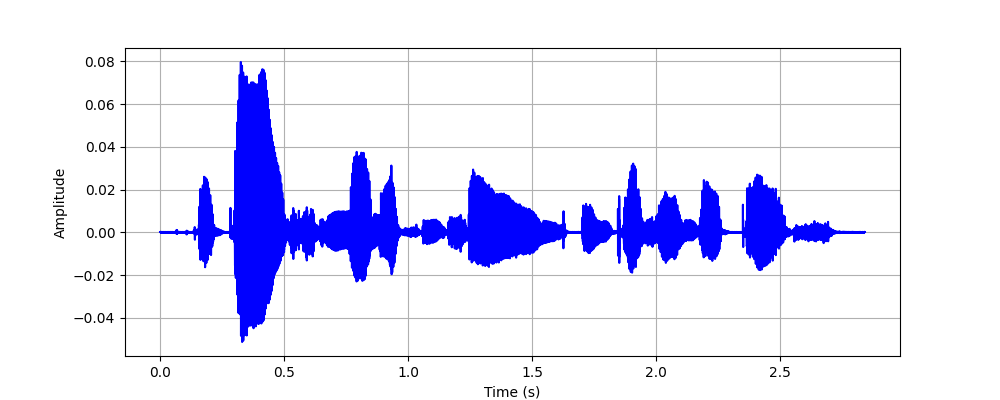

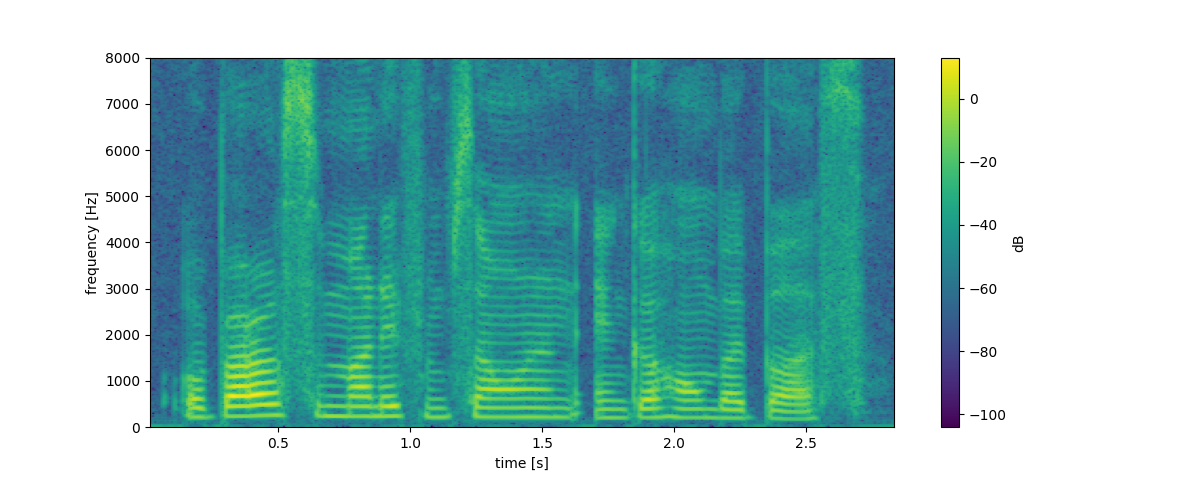

In [2]:
y, sr = librosa.load(file, sr=None)

plot_signal(y, sr)

v_hann_window = get_window("hann", int(sr * 32 / 1000), True)
plot_log_magnitude(*compute_stft(y, sr, 32, 8, v_hann_window))

2. Select one unvoiced and one voiced speech segment from the signal, each with a length of 32 ms. You may reuse
your segmentation from Assignment 3 of Exercise 1 and/or your knowledge about the speech signal obtained in
assignment 1b) of Exercise 1. Apply a Hann window of the same length to both segments

In [3]:
segment_length_ms = 32

def get_segment(y: np.ndarray, t0_ms: int, length_ms: int = 32) -> np.ndarray:
    # convert ms to samples
    length = int(sr * length_ms / 1000)
    t0 = int(sr * t0_ms / 1000)
    t1 = t0 + length
    
    # get segment
    v_seg = y[t0:t1]
    
    return v_seg

v_hann_window = get_window("hann", int(sr * segment_length_ms / 1000), True)

voiced_frame = get_segment(y, 300)
unvoiced_frame = get_segment(y, 550)

windowed_voiced_frame = voiced_frame * v_hann_window
windowed_unvoiced_frame = unvoiced_frame * v_hann_window

3. Compute the $M = 12$-order LP coefficients by solving equation 4. Use the functions `np.correlate` and `scipy.linalg.solve_toeplitz` to compute the autocorrelation vector $\phi_s$ and the correlation matrix $R_s$ respectively. Store the coefficients in a vector $a$.

In [4]:
# uses Burg's Algrorithm instead of the autocorrelation method
print("Control: Librosa Linear Prediction Coefficients (voiced segment)\n", librosa.lpc(windowed_voiced_frame, order=12))
print("Control: Librosa Linear Prediction Coefficients (voiced segment)\n", librosa.lpc(windowed_unvoiced_frame, order=12))

Control: Librosa Linear Prediction Coefficients (voiced segment)
 [ 1.         -2.71947183  2.43385814  0.30427874 -2.34438971  1.79651275
  0.13282822 -1.24591612  0.92271324 -0.17107457 -0.01581462 -0.14877414
  0.12690826]
Control: Librosa Linear Prediction Coefficients (voiced segment)
 [1.         0.94438622 0.14828399 0.21340102 0.36157487 0.3282959
 0.4661365  0.20472209 0.17252326 0.3037789  0.12122428 0.02902136
 0.08407856]


In [12]:
def get_coefficients(signal: np.ndarray, lpc_order: int = 12) -> np.ndarray:
    # compute the autocorrelation vector
    phi_full = np.correlate(signal, signal, mode="full")  # mode "valid" | "full"

    # autocorrelation is symmetric, we only need one half
    center = len(phi_full) // 2
    phi = phi_full[center:center + lpc_order + 1]

    # The right-hand side vector is the remaining part
    b = phi[1:]

    # Solve for the LPC coefficients
    a = solve_toeplitz((phi[:-1], phi[:-1]), b)

    return -a

a_voiced = get_coefficients(windowed_voiced_frame)
print("Linear Prediction Coefficients (voiced segment):\n", a_voiced)

a_unvoiced = get_coefficients(windowed_unvoiced_frame)
print("Linear Prediction Coefficients (unvoiced segment):\n", a_unvoiced)

Linear Prediction Coefficients (voiced segment):
 [-2.71947241  2.43385937  0.30427807 -2.34439051  1.79651446  0.1328271
 -1.24591675  0.92271501 -0.17107573 -0.01581519 -0.14877269  0.12690752]
Linear Prediction Coefficients (unvoiced segment):
 [0.94438624 0.148284   0.21340097 0.36157487 0.32829589 0.46613646
 0.20472208 0.17252316 0.30377886 0.12122441 0.02902129 0.08407841]


4a) Make a plot of the frequency response (amplitude as well as phase) of the estimated vocal tract filter $H(z)$ for both, the unvoiced and the voiced speech segment. To do this, the command `scipy.signal.freqz(1, np.concatenate(([1], a)), numPoints, whole=True, fs=sampling_freq)` might be helpful. For the number of frequency-points (`numPoints`), use the segment length in samples. Make sure that the axis descriptions of your plots is meaningful.

4b) Why do you use `np.concatenate(([1], a))` and not only a?

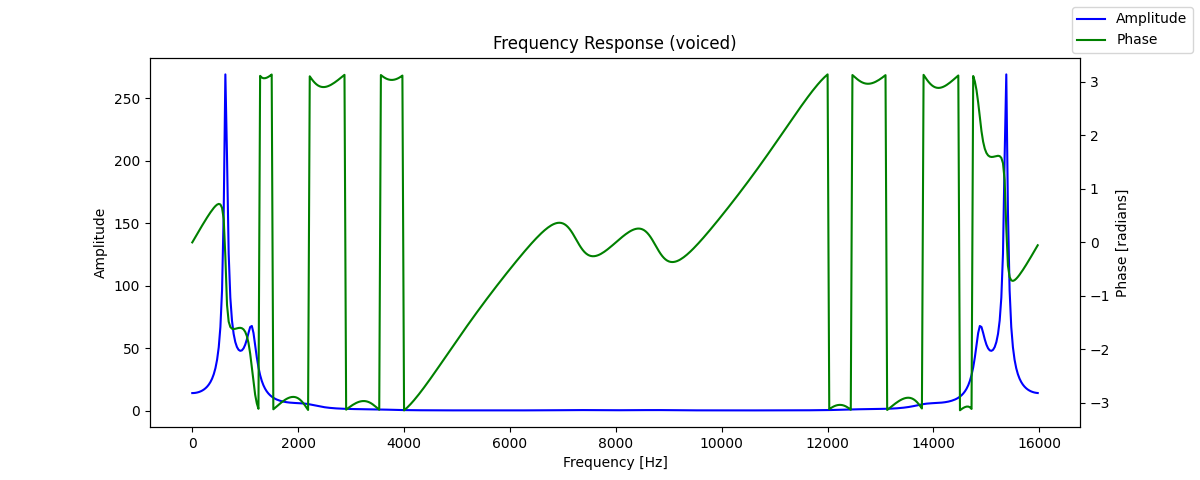

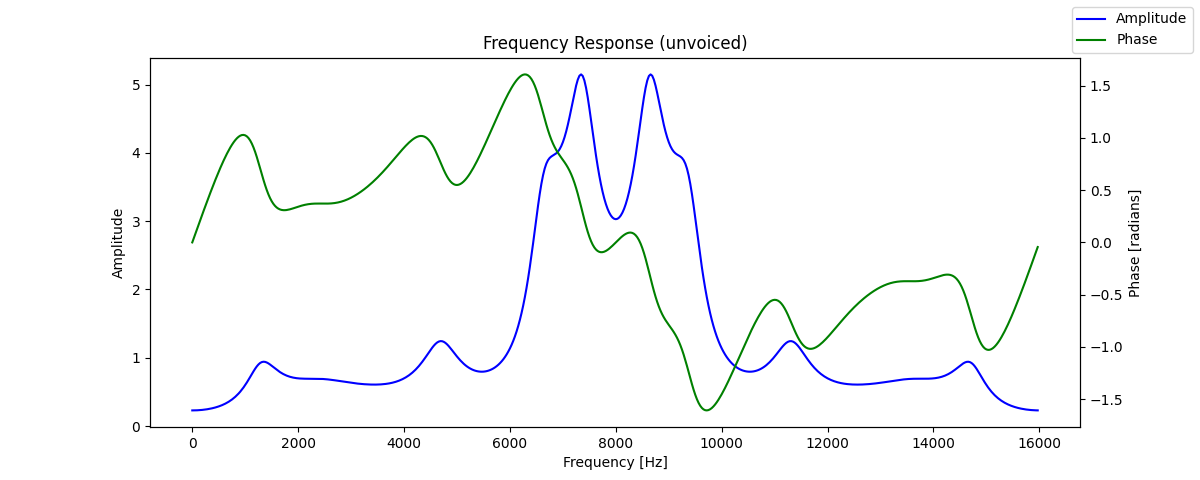

In [6]:
def plot_freq_response(a: np.ndarray, num_points: int, title: str = "", plot_phase: bool = True):
    # compute the frequency response of the digital filter
    #   w: the frequencies at which h was computed
    #   h: the frequency response, as complex numbers.
    w, h = freqz(1, np.concatenate(([1], a)), num_points, whole=True, fs=sr)
    
    fig, ax1 = plt.subplots()
    fig.set_figwidth(12)
    ax1.set_title(f"Frequency Response ({title})")

    # plot amplidute 
    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Amplitude")
    ax1.plot(w, np.abs(h), "b", label="Amplitude")

    # plot phase
    if plot_phase:
        ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
        ax2.set_ylabel("Phase [radians]")
        ax2.plot(w, np.angle(h), "g", label="Phase")

    fig.legend()

num_points = int(sr * 32 / 1000)

plot_freq_response(a_voiced, num_points, "voiced")
plot_freq_response(a_unvoiced, num_points, "unvoiced")

5. Compute the discrete Fourier transform (DFT) of the windowed segments using `S = np.fft.rfft(...)`. Plot the
amplitude of $S$ in $dB$ together with the amplitude of the corresponding filter $H(z)$ in $dB$ in one plot.

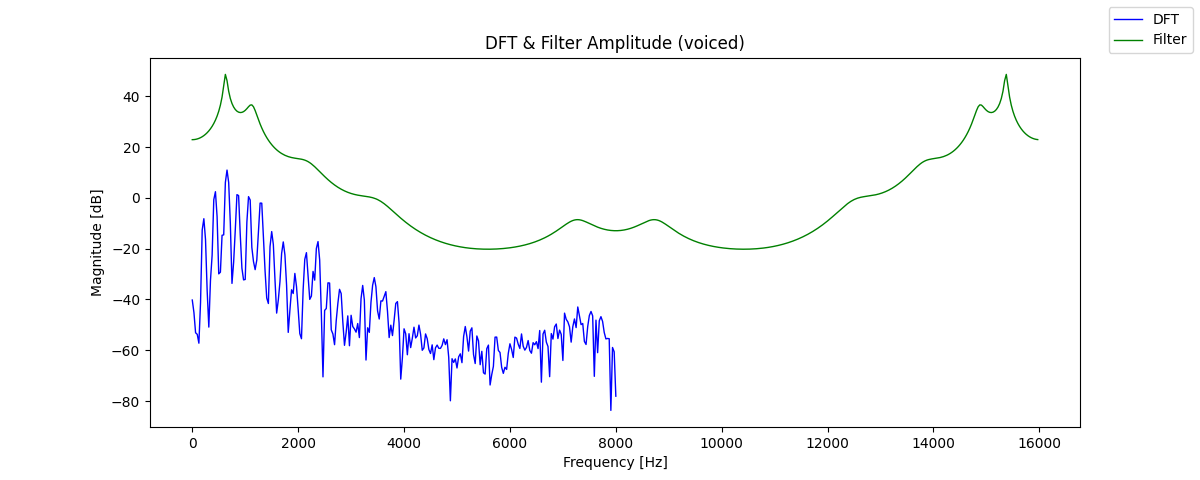

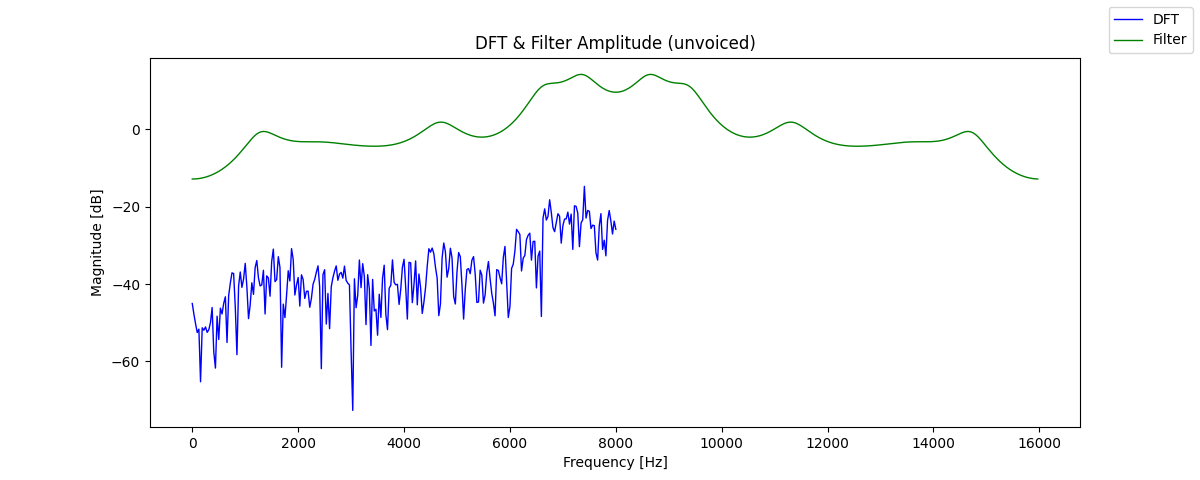

In [7]:
def plot_dft_amplitude(y: np.ndarray, a: np.ndarray, num_points: int, title: str = ""):
    S = np.fft.rfft(y)
    S_freq = np.fft.rfftfreq(num_points, 1/sr)

    w, h = freqz(1, np.concatenate(([1], a)), num_points, whole=True, fs=sr)

    fig, ax1 = plt.subplots()
    fig.set_figwidth(12)

    ax1.set_title(f"DFT & Filter Amplitude ({title})")
    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Magnitude [dB]")
    ax1.plot(S_freq, 20*np.log10(np.abs(S)), "b", label="DFT", linewidth=1)

    ax1.plot(w, 20*np.log10(np.abs(h)), "g", label="Filter", linewidth=1)

    fig.legend()

plot_dft_amplitude(windowed_voiced_frame, a_voiced, num_points, "voiced")
plot_dft_amplitude(windowed_unvoiced_frame, a_unvoiced, num_points, "unvoiced")

**6a) For both segments, compute the residual signal by using the inverse filtering statement `e = scipy.signal.lfilter(np.concatenate(([1], a)), 1, s)`. Plot the residual signal $e$ together with the corresponding signal segment.**

**b) Explain differences in $e$ between the voiced and unvoiced segment.**

*The residual signal represents the part of the signal not captured by the model.*

Voiced Segment
- The residual signal of the voiced signal is very small / almost flat.
- The voiced signal has a strong periodic nature with strong fundamental frequencies and harmonies, allowing the model to effectively capture the signal.

Unvoiced Segment
- The residual signal of the unvoiced segment is much more significant / of higher amplitude.
- Unvoiced sounds are much more noise-like without clear periodic structure.
- The sound is spread over a wider frequency range.
- The model performs worse at capturing these signals.

**c) Explain why `scipy.signal.lfilter(np.concatenate(([1], a)), 1, s)` yields the residual signal.**

- The filter with the coefficients $[1, a_1, ..., a_i]$ is u sed to predict the signal based on its past samples.
- Inverse filtering with the LPC coefficients removed the predicted part from the signal yielding the residual signal.
- when using `scipy.signal.lfilter(np.concatenate(([1], a)), 1, s)` we apply the inverse filter to the signal.

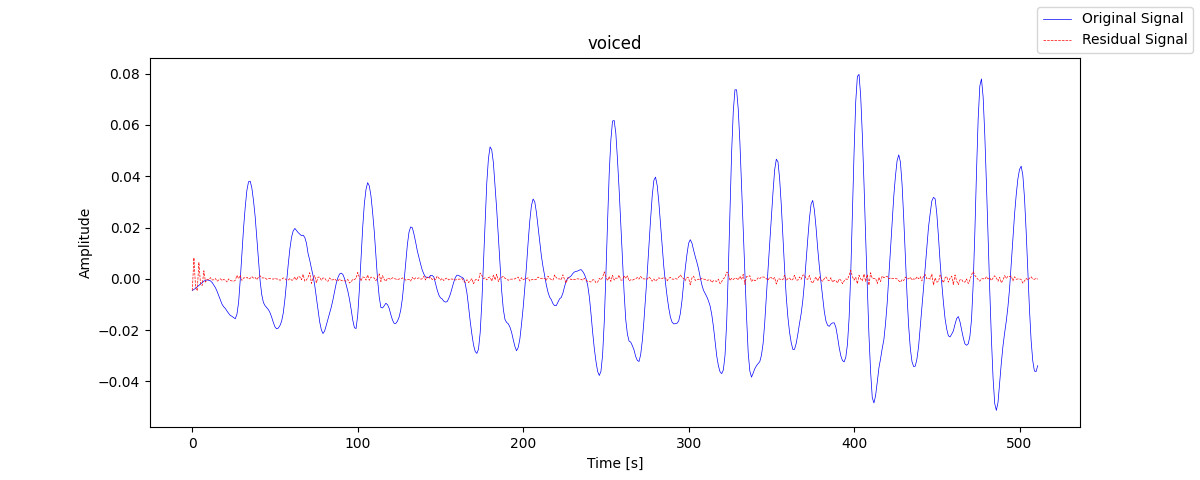

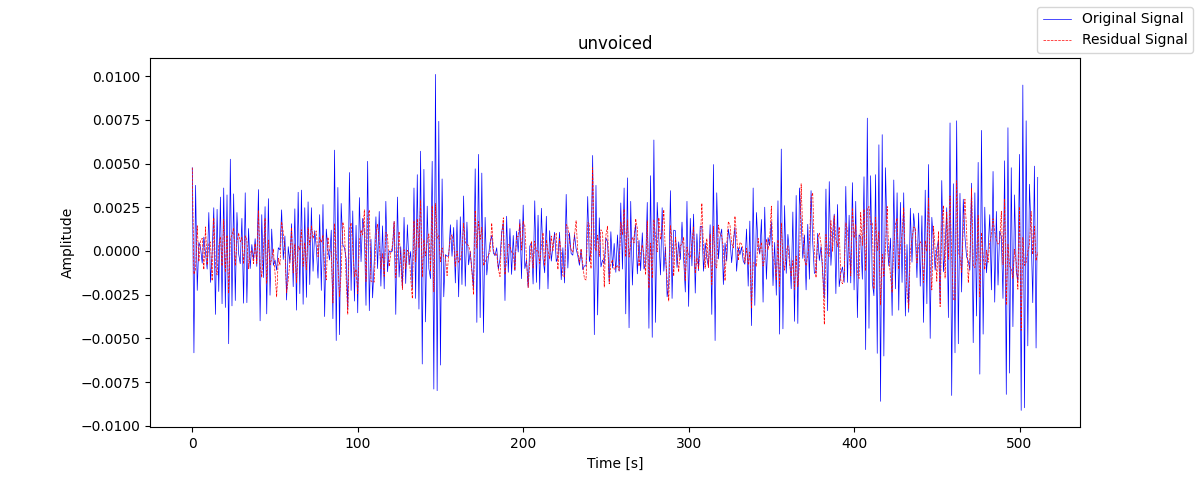

In [8]:
def plot_filter(signal: np.ndarray, a: np.ndarray, title:str = ""):
    e = lfilter(np.concatenate(([1], a)), 1, signal)

    fig, ax1 = plt.subplots()
    fig.set_figwidth(12)

    ax1.set_title(title)
    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel("Amplitude")
    ax1.plot(signal, "b", label="Original Signal", linewidth=0.5)

    ax1.plot(e, "r", label="Residual Signal", linestyle="--", linewidth=0.5)

    fig.legend()
    
plot_filter(voiced_frame, a_voiced, "voiced")
plot_filter(unvoiced_frame, a_unvoiced, "unvoiced")

**7a) Why are the logarithmic amplitudes of H and S (plots of assignment 5) not on the same level?**

- The amplitude of the filter is typcially normalized.
- The amplitude of the DFT is directly tied to the amplitude of the input signal.
- The amplitude levels of the filter response are determined by the LPC coefficients and do not directly represent the absolute level of energy.

**b) How can you modify H to achieve a better match? Hint: Experiment with the energy of the residual e.**

- We could scale the filter response using the residual energy.
- The root mean square (RMS) of a signal yields the average magnitude
- Using the RMS of the residual signal $e$ and the DFT $S$ we can calclulate the scaling factor $sf = \frac{RMS(e)}{RMS(S)}$

**c) For the voiced speech segment, plot the amplitude of the modified filter H together with the amplitude of S in dB to check if your modification is correct.**

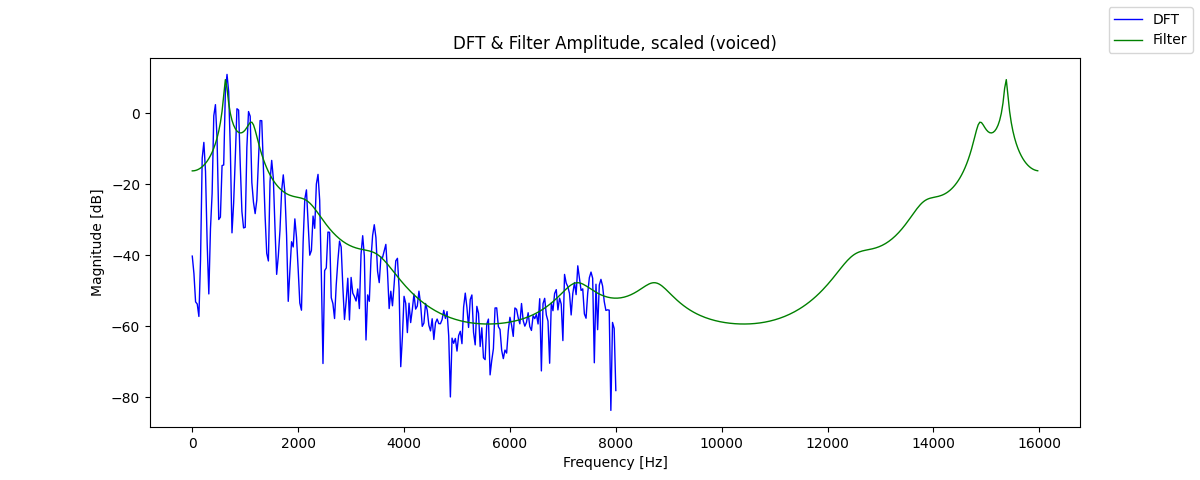

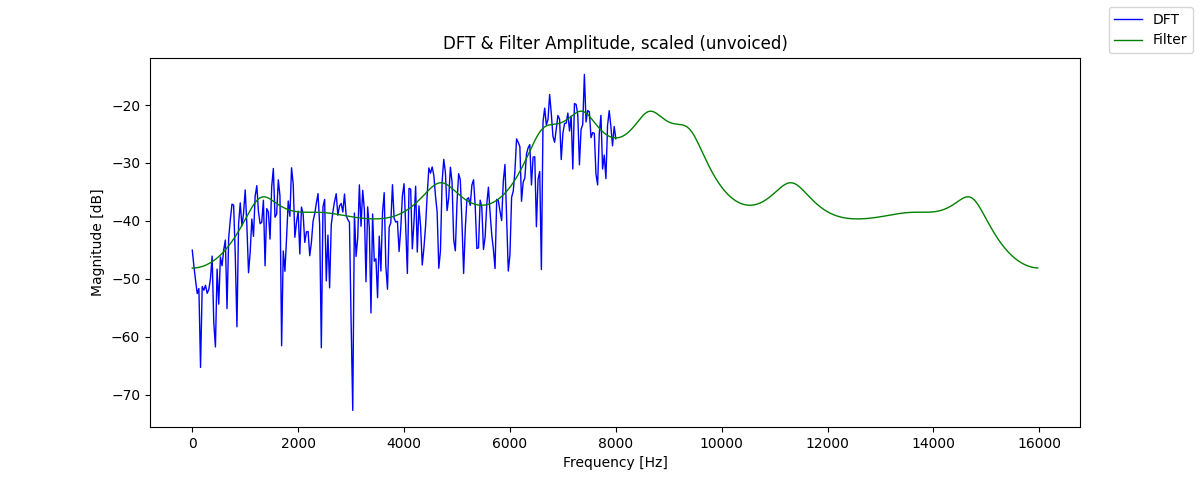

In [18]:
def plot_dft_amplitude_scaled(frame: np.ndarray, windowed_frame: np.ndarray, a: np.ndarray, num_points: int, title: str = ""):
    # calculate the DFT
    S = np.fft.rfft(windowed_frame, num_points)
    S_freq = np.fft.rfftfreq(num_points, 1/sr)

    # calculate the frequency response 
    w, h = freqz(1, np.concatenate(([1], a)), num_points, whole=True, fs=sr)

    # calculate offset to normalize the frequency respnse
    offset_s = np.sqrt(np.linalg.norm(S)**2 / len(S))
    offset_h = np.sqrt(np.linalg.norm(h)**2 / len(h))
    
    # apply filter to get residual energy
    e = lfilter(np.concatenate(([1], a)), 1, frame)

    # caclulate the RMS (root mean square)
    rms_e = np.sqrt(np.mean(e**2))
    rms_s = np.sqrt(np.mean(S**2))

    # scale h using the scaling factor/RMS
    # h_scaled = h * np.mean(frame**2)
    h_scaled = h * (offset_s / offset_h)

    fig, ax1 = plt.subplots()
    fig.set_figwidth(12)

    ax1.set_title(f"DFT & Filter Amplitude, scaled ({title})")
    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Magnitude [dB]")
    ax1.plot(S_freq, 20*np.log10(np.abs(S)), "b", label="DFT", linewidth=1)

    ax1.plot(w, 20*np.log10(np.abs(h_scaled)), "g", label="Filter", linewidth=1)

    fig.legend()

# plot_dft_amplitude(windowed_voiced_frame, a_voiced, num_points, "voiced")
plot_dft_amplitude_scaled(voiced_frame, windowed_voiced_frame, a_voiced, num_points, "voiced")
plot_dft_amplitude_scaled(unvoiced_frame, windowed_unvoiced_frame, a_unvoiced, num_points, "unvoiced")


8. Play with the order of the predictor $(M = 2 .. 20)$. Describe differences in $H(z)$ and explain reasons for that.

When using higher order predictors, $H(z)$ has
- higher precision/accuracy
- frequencies with lower amplitude are becoming visible
- reduced residual error (better prediction)

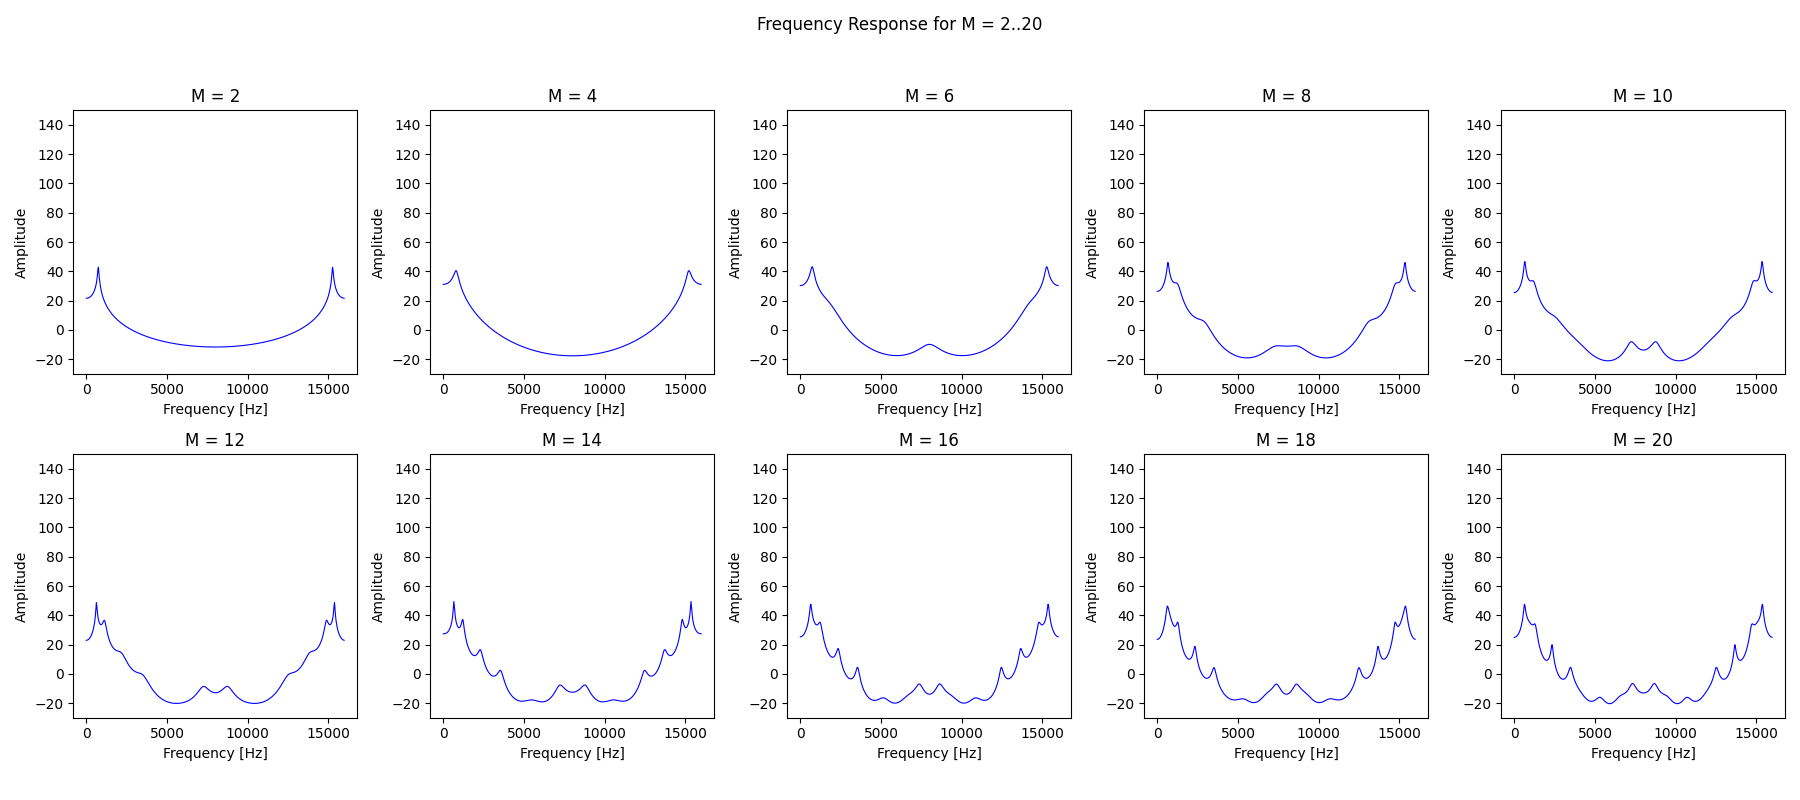

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle("Frequency Response for M = 2..20")

axes = axes.flatten()

ylim = (-30, 150)

plot_idx = 0
for i in range(2, 21, 2):
    a_M = get_coefficients(windowed_voiced_frame, i)

    w, h = freqz(1, np.concatenate(([1], a_M)), num_points, whole=True, fs=sr)

    ax = axes[plot_idx]
    ax.set_title(f"M = {i}")
    ax.set_xlabel("Frequency [Hz]")
    ax.set_ylabel("Amplitude")
    ax.plot(w, 20*np.log10(np.abs(h)), "b", label="Amplitude", linewidth=0.8)
    # ax.plot(w, np.abs(h), "b", label="Amplitude", linewidth=0.8)
    ax.set_ylim(ylim)
    plot_idx += 1

    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


9\. From the speech production model it is known that speech undergoes a spectral tilt of −6 dB/octave. To counteract this effect, a pre-emphasis filter of the following form is used:
$$
y(n) = s(n) −\alpha s(n−1)
$$

**a) Compute the LP coefficients for the pre-emphasized voiced speech segment using function `scipy.signal.lfilter` and $\alpha = 0.95$. Compare the results with and without pre-emphasis.**

- The pre-emphasized signal shows less significant lower frequencies and more significant higher frequencies

**b) What is the advantage of pre-emphasizing the speech signal?**

- Increased precision of the higher frequencies of human speech

LP coefficients without pre-emphasis:
 [-2.71947241  2.43385937  0.30427807 -2.34439051  1.79651446  0.1328271
 -1.24591675  0.92271501 -0.17107573 -0.01581519 -0.14877269  0.12690752]
LP coefficients with pre-emphasis:
 [-1.93256017  0.87644087  1.04708439 -1.45199029  0.34071518  0.79993886
 -0.68236643 -0.12498024  0.4409171   0.16629941 -0.67407188  0.40895579]


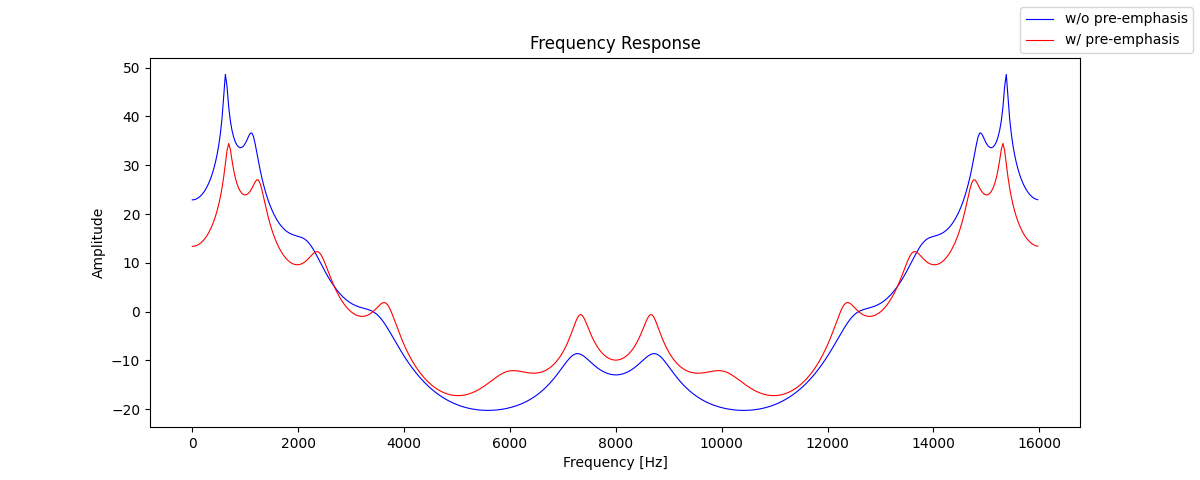

In [21]:
# y[n] -> y[n] - alpha * y[n-1]
def pre_emphasis(signal: np.ndarray, alpha: float) -> np.ndarray:
    return lfilter([1, -alpha], 1, signal)

a_voiced = get_coefficients(windowed_voiced_frame, 12)

pre_emphasized_segment = pre_emphasis(windowed_voiced_frame, 0.95)
a_pre_emphasized = get_coefficients(pre_emphasized_segment, 12)

# Print LP coefficients
print("LP coefficients without pre-emphasis:\n", a_voiced)
print("LP coefficients with pre-emphasis:\n", a_pre_emphasized)

w, h = freqz(1, np.concatenate(([1], a_voiced)), num_points, whole=True, fs=sr)
w_p, h_p = freqz(1, np.concatenate(([1], a_pre_emphasized)), num_points, whole=True, fs=sr)

fig, ax1 = plt.subplots()
fig.set_figwidth(12)
ax1.set_title(f"Frequency Response")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Amplitude")

ax1.plot(w, 20*np.log10(np.abs(h)), "b", label="w/o pre-emphasis", linewidth="0.8")
ax1.plot(w_p, 20*np.log10(np.abs(h_p)), "r", label="w/ pre-emphasis", linewidth="0.8")

# ax2 = ax1.twinx()
# ax2.plot(w_p, np.abs(h_p), "g", label="w/ pre-emphasis", linewidth="0.8")

fig.legend()